In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

import torch

In [2]:
dataset_name = 'adult'
bb_name = 'nn'

In [3]:
from exp.data_loader import load_tabular_data
from exp.bb_loader import load_bb
X_train, X_test, y_train, y_test = load_tabular_data(dataset_name)
y_train_pred, y_test_pred, clf = load_bb(X_train, X_test, dataset_name, bb_name)
X_train = np.hstack((X_train,y_train_pred.reshape(-1,1)))
y_train = y_train.values
X_test = np.hstack((X_test,y_test_pred.reshape(-1,1)))
y_test = y_test.values

2022-04-12 16:10:57.580166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 16:10:57.595751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:258] None of the MLIR optimization passes are enabled (registered 0 passes)


In [4]:
import numpy as np
from sklearn import datasets, svm
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, LocalOutlierFactor
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist, pdist
from numpy.random import default_rng
from collections import Counter
from sklearn.cluster import KMeans
from numpy.linalg import norm

def knn_clf(nbr_vec, y):
    '''
    Helper function to generate knn classification result.
    '''
    y_vec = y[nbr_vec]
    c = Counter(y_vec)
    return c.most_common(1)[0][0]

def knn_eval_series(X, y, n_neighbors_list=[1, 2, 3, 4, 5, 10, 15, 20], n_jobs=-1):
    '''
    This is a function that is used to evaluate the lower dimension embedding.
    An accuracy is calculated by an k-nearest neighbor classifier.
    A series of accuracy will be calculated for the given n_neighbors.
    Input:
        X: A numpy array with the shape [N, k]. The lower dimension embedding
           of some dataset. Expected to have some clusters.
        y: A numpy array with the shape [N, 1]. The labels of the original
           dataset.
        n_neighbors_list: A list of int.
        kwargs: Any keyword argument that is send into the knn clf.
    Output:
        accs: The avg accuracy generated by the clf, using leave one out cross val.
    '''
    avg_accs = []
    max_acc = X.shape[0]
    # Train once, reuse multiple times
    nbrs = NearestNeighbors(n_neighbors=n_neighbors_list[-1]+1, n_jobs=n_jobs).fit(X)
    distances, indices = nbrs.kneighbors(X)
    indices = indices [:, 1:]
    distances = distances[:, 1:]
    for n_neighbors in n_neighbors_list:
        sum_acc = 0
        for i in range(X.shape[0]):
            indices_temp = indices[:, :n_neighbors]
            result = knn_clf(indices_temp[i], y)
            if result == y[i]:
                sum_acc += 1
        avg_acc = sum_acc / max_acc
        avg_accs.append(avg_acc)
    return 1-np.array(avg_accs)

def random_triplet_eval(X, X_new, y):
    '''
    This is a function that is used to evaluate the lower dimension embedding.
    An triplet satisfaction score is calculated by evaluating how many randomly
    selected triplets have been violated. Each point will generate 5 triplets.
    Input:
        X: A numpy array with the shape [N, p]. The higher dimension embedding
           of some dataset. Expected to have some clusters.
        X_new: A numpy array with the shape [N, k]. The lower dimension embedding
               of some dataset. Expected to have some clusters as well.
        y: A numpy array with the shape [N, 1]. The labels of the original
           dataset. Used to identify clusters
    Output:
        acc: The score generated by the algorithm.
    '''    

    # Sampling Triplets
    # Five triplet per point
    anchors = np.arange(X.shape[0])
    rng = default_rng()
    triplets = rng.choice(anchors, (X.shape[0], 5, 2))
    triplet_labels = np.zeros((X.shape[0], 5))
    anchors = anchors.reshape((-1, 1, 1))
    
    # Calculate the distances and generate labels
    b = np.broadcast(anchors, triplets)
    distances = np.empty(b.shape)
    distances.flat = [np.linalg.norm(X[u] - X[v]) for (u,v) in b]
    labels = distances[:, :, 0] < distances[: , :, 1]

    # Calculate distances for LD
    b = np.broadcast(anchors, triplets)
    distances_l = np.empty(b.shape)
    distances_l.flat = [np.linalg.norm(X_new[u] - X_new[v]) for (u,v) in b]
    pred_vals = distances_l[:, :, 0] < distances_l[:, :, 1]
    correct = np.sum(pred_vals == labels)
    acc = correct/X.shape[0]/5
    return acc

def lof_eval(X, Z, n_jobs=-1):
    clf = LocalOutlierFactor(n_jobs=n_jobs)
    clf.fit(X)
    outlier_factor_input_space = clf.negative_outlier_factor_
    clf = LocalOutlierFactor(n_jobs=n_jobs)
    clf.fit(Z)
    outlier_factor_latent_space = clf.negative_outlier_factor_
    lof_score = np.mean((outlier_factor_input_space-outlier_factor_latent_space)**2)
    return lof_score
 
def isf_eval(X, Z, n_jobs=-1):
    clf = IsolationForest(n_jobs=n_jobs)
    clf.fit(X)
    outlier_factor_input_space = clf.score_samples(X)
    clf = IsolationForest(n_jobs=n_jobs)
    clf.fit(Z)
    outlier_factor_latent_space = clf.score_samples(Z)
    isf_score = np.mean((outlier_factor_input_space-outlier_factor_latent_space)**2)
    return isf_score

def sse_eval(Z):
    kmeans = KMeans(n_clusters=2).fit(Z)
    sse_score = kmeans.inertia_
    return sse_score

def spars_eval(model, Z):
    y_contrib = model.fc1.weight.detach().numpy()[:,-1]
    thetas = np.arccos(np.round(np.dot(Z/norm(Z,axis=1).reshape(-1,1),y_contrib/norm(y_contrib)),5))
    spars_score = np.quantile(np.linalg.norm(Z)*np.cos(thetas),0.75)
    return spars_score


def compute_metrics(model, X, Z, Y, n_jobs=-1):    
    knn_score = np.mean(knn_eval_series(Z, Y, n_jobs=n_jobs))
    triplet_score = random_triplet_eval(X, Z, Y)
    lof_score = lof_eval(X, Z, n_jobs=n_jobs)
    isf_score = isf_eval(X, Z, n_jobs=n_jobs)
    sse_score = sse_eval(Z)
    spars_score = spars_eval(model, Z)
    return {'KNN':knn_score,
            'Triplet':triplet_score,
            'LOF':lof_score,
            'IsF':isf_score,
            'sse':sse_score,
            'spars':spars_score}


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()
        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)
    def encode(self, x):
        x = self.fc1(x)
        return x
    def forward(self, x):
        z = self.encode(x)
        return z


latent_dim = 4
alphas = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5]
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)
metrics = []

for alpha in alphas:
    model.load_state_dict(torch.load(f'./latent_analysis_models/{dataset_name}_latent_{bb_name}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()
    
    metrics.append(compute_metrics(model, X_train, Z_train, y_train))

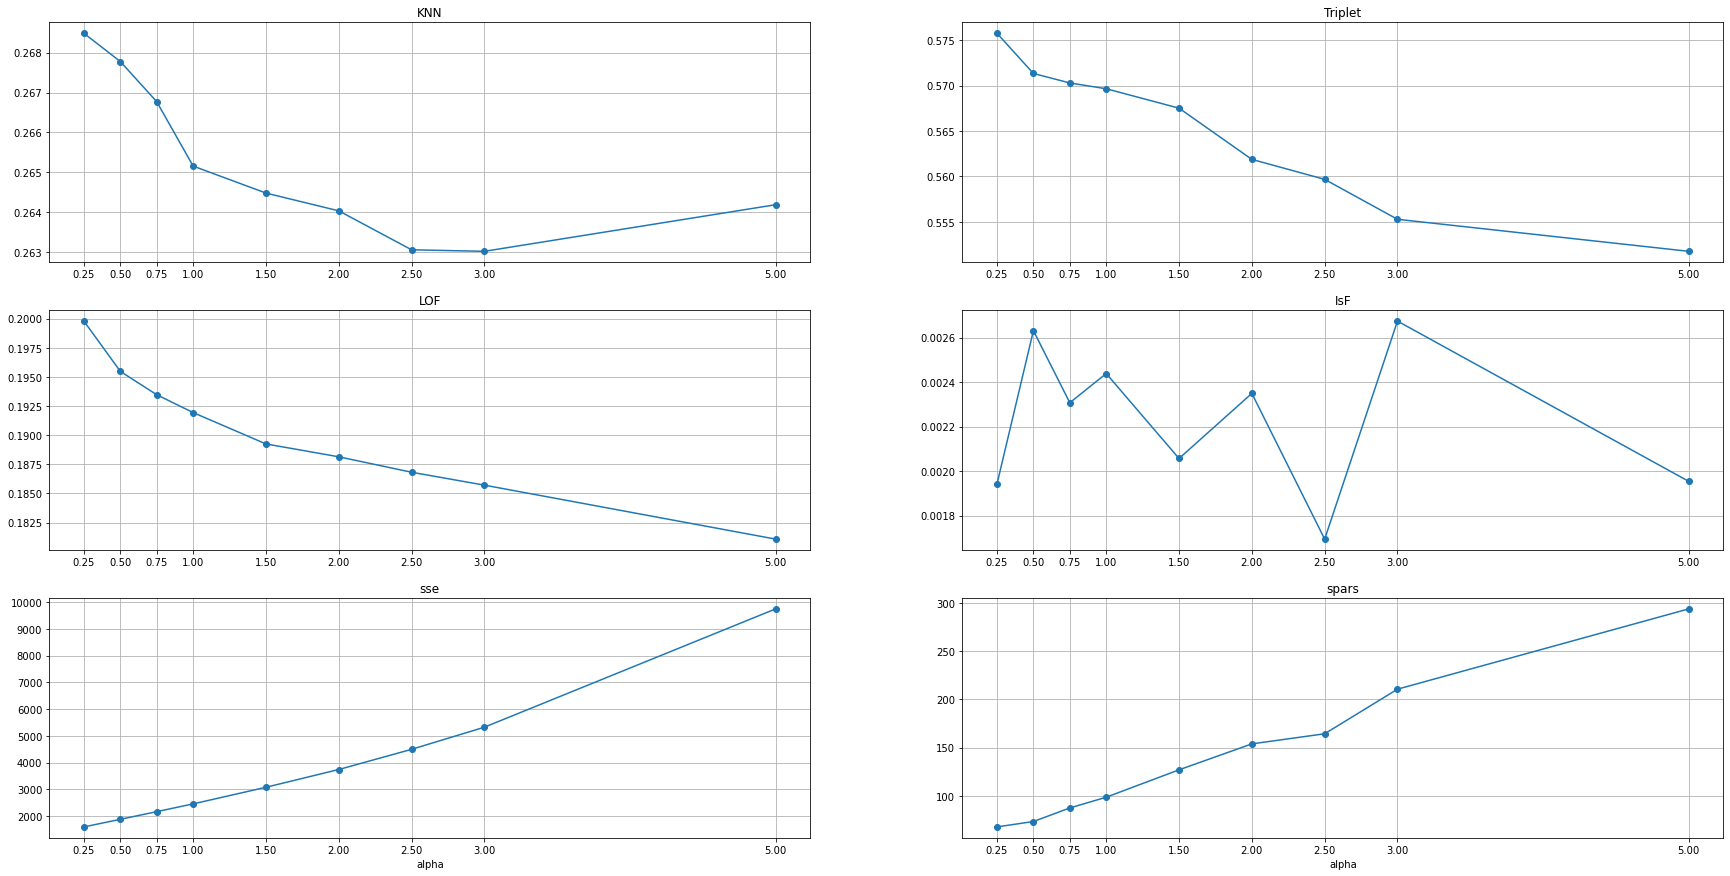

In [6]:
fig, ax = plt.subplots(3,2,figsize=(30,15))
ax.ravel()[0].plot(alphas,[r['KNN'] for r in metrics], '-o')
ax.ravel()[0].grid()
ax.ravel()[0].set_xticks(alphas)
ax.ravel()[0].set_title('KNN')
ax.ravel()[1].plot(alphas,[r['Triplet'] for r in metrics], '-o')
ax.ravel()[1].grid()
ax.ravel()[1].set_xticks(alphas)
ax.ravel()[1].set_title('Triplet')
ax.ravel()[2].plot(alphas,[r['LOF'] for r in metrics], '-o')
ax.ravel()[2].grid()
ax.ravel()[2].set_xticks(alphas)
ax.ravel()[2].set_title('LOF')
ax.ravel()[3].plot(alphas,[r['IsF'] for r in metrics], '-o')
ax.ravel()[3].grid()
ax.ravel()[3].set_xticks(alphas)
ax.ravel()[3].set_title('IsF')
ax.ravel()[4].plot(alphas,[r['sse'] for r in metrics], '-o')
ax.ravel()[4].grid()
ax.ravel()[4].set_xticks(alphas)
ax.ravel()[4].set_title('sse')
ax.ravel()[4].set_xlabel('alpha')
ax.ravel()[5].plot(alphas,[r['spars'] for r in metrics], '-o')
ax.ravel()[5].grid()
ax.ravel()[5].set_xticks(alphas)
ax.ravel()[5].set_title('spars')
ax.ravel()[5].set_xlabel('alpha')
plt.savefig(f'/Users/francescobodria/Desktop/plots/{dataset_name}_{bb_name}_latent_{latent_dim}_space_metrics.jpeg', bbox_inches='tight')

In [8]:
if bb_name in ['xgb', 'rf', 'svc']:
    def predict(x, return_proba=False):
        if return_proba:
            return clf.predict_proba(x)[:,1].ravel()
        else: return clf.predict(x).ravel().ravel()
else:
    def predict(x, return_proba=False):
        if return_proba:
            return clf.predict(x).ravel()
        else: return np.round(clf.predict(x).ravel()).astype(int).ravel()

def compute_cf(q, indexes):
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
    if q_pred > 0.5:
        m = -0.1
    else:
        m = +0.1
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        v = np.array(model(torch.tensor(q_cf).float()).detach().numpy()+m*y_contrib)
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        #print(delta_i)
        q_cf[indexes] += delta_i
        if float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)) in q_cf_preds:
            return q_cf
        q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
        q_cf[-1] = q_cf_preds[-1]
    return q_cf

d_dists = []
d_impls = []
d_advs = []

for alpha in alphas:
    model.load_state_dict(torch.load(f'./latent_analysis_models/{dataset_name}_latent_{bb_name}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()
    
    w = model.fc1.weight.detach().numpy()
    b = model.fc1.bias.detach().numpy()
    y_contrib = model.fc1.weight.detach().numpy()[:,-1]

    from itertools import combinations
    from tqdm.notebook import tqdm

    if dataset_name == 'fico':
        idx_len = 24
    elif dataset_name == 'adult':
        idx_len = 7
    elif dataset_name == 'compas':
        idx_len = 34
    elif dataset_name == 'german':
        idx_len = 72

    d_dist = []
    d_impl = []
    d_adv = []

    for idx in tqdm(range(10)):
        q = X_test[idx,:].copy()
        q_pred = predict(q[:-1].reshape(1,-1),return_proba=False)
        q_cfs = []
        l_i = []
        l_f = []

        for indexes in list(combinations(list(range(idx_len)),1)):    
            q_cf = compute_cf(q, list(indexes))
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if q_pred:
                if q_cf_pred<0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf) 

        for indexes in  list(combinations(list(range(idx_len)),2)):    
            q_cf = compute_cf(q, list(indexes))
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if q_pred:
                if q_cf_pred<0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf) 
            l_i.append([list(indexes),q_cf_pred])
        r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
        l_i = np.array(l_i,dtype=object)[r,0]

        while len(l_i[0])<6:
            for e in l_i:
                for i in list(np.delete(range(idx_len),e)):
                    q_cf = compute_cf(q, e+[i])
                    q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
                    if q_pred:
                        if q_cf_pred<0.5:
                            q_cfs.append(q_cf)
                    else:
                        if q_cf_pred>0.5:
                            q_cfs.append(q_cf) 
                    l_f.append([e+[i],q_cf_pred])
            r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
            l_f = np.array(l_f,dtype=object)[r,0]
            l_i = l_f.copy()
            l_f = []
        
        if len(q_cfs)<1:
            continue
        else:
            q_cfs = np.vstack(q_cfs)
            if dataset_name == 'fico':
                d_dist.append(np.min(cdist(q_cfs[:,:-1],q[:-1].reshape(1,-1))))
                d_impl.append(np.min(cdist(q_cfs[:,:-1],X_train[:,:-1])))
                r = np.argsort(cdist(q_cfs[:,:-1],X_train[:,:-1]),axis=1)[:,:10]
                d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
            elif dataset_name == 'compas':
                d_dist.append(np.min(cdist(q_cfs[:,13:-1],q[13:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:13],q[:13].reshape(1,-1),metric='euclidean')))
                d_impl.append(np.min(cdist(q_cfs[:,13:-1],X_train[:,13:-1],metric='hamming') + cdist(q_cfs[:,:13],X_train[:,:13],metric='euclidean')))
                r = np.argsort(cdist(q_cfs[:,13:-1],X_train[:,13:-1],metric='hamming') + cdist(q_cfs[:,:13],X_train[:,:13],metric='euclidean'),axis=1)[:,:10]
                d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
            elif dataset_name == 'adult':
                d_dist.append(np.min(cdist(q_cfs[:,[2,3,4,5,6]],q[[2,3,4,5,6]].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,[0,1]],q[[0,1]].reshape(1,-1),metric='euclidean')))
                d_impl.append(np.min(cdist(q_cfs[:,[2,3,4,5,6]],X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cfs[:,[0,1]],X_train[:,[0,1]],metric='euclidean')))
                r = np.argsort(cdist(q_cfs[:,[2,3,4,5,6]],X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cfs[:,[0,1]],X_train[:,[0,1]],metric='euclidean'),axis=1)[:,:10]
                d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
            elif dataset_name == 'german':
                d_dist.append(np.min(cdist(q_cfs[:,3:-1],q[3:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:3],q[:3].reshape(1,-1),metric='euclidean')))
                d_impl.append(np.min(cdist(q_cfs[:,3:-1],X_train[:,3:-1],metric='hamming') + cdist(q_cfs[:,:3],X_train[:,:3],metric='euclidean')))
                r = np.argsort(cdist(q_cfs[:,3:-1],X_train[:,3:-1],metric='hamming') + cdist(q_cfs[:,:3],X_train[:,:3],metric='euclidean'),axis=1)[:,:10]
                d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
    d_dists.append(np.mean(np.array(d_dist)))
    d_impls.append(np.mean(np.array(d_impl)))
    d_advs.append(np.mean(np.array(d_adv)))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

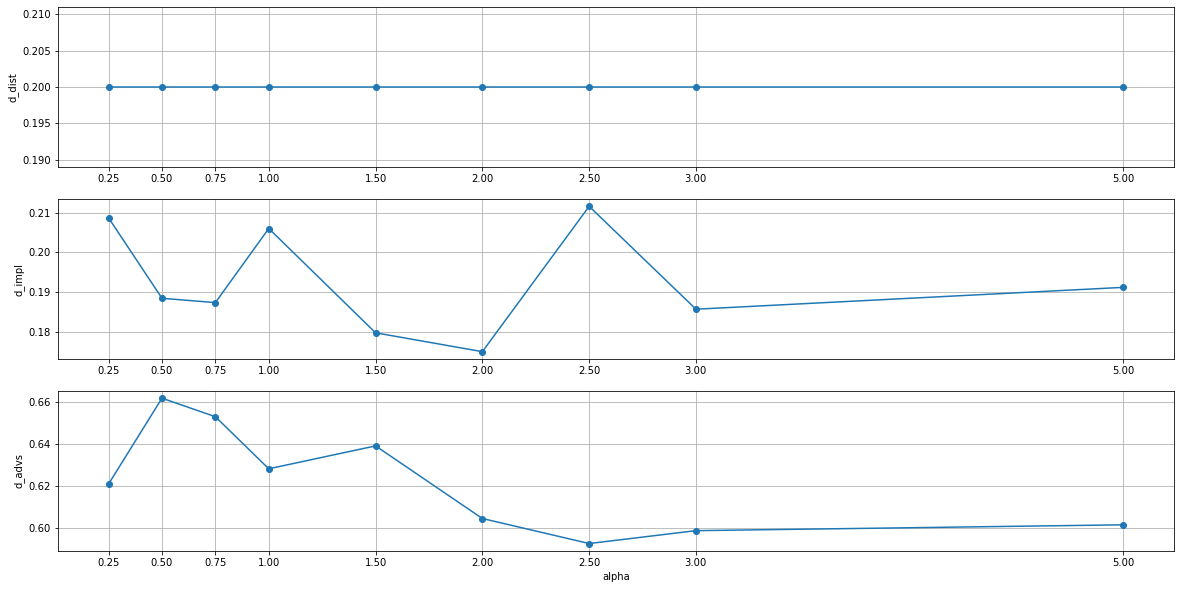

In [9]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(alphas,d_dists,'-o')
ax[0].set_ylabel('d_dist')
ax[0].set_xticks(alphas)
ax[0].grid(True)
ax[1].plot(alphas,d_impls,'-o')
ax[1].set_ylabel('d_impl')
ax[1].grid(True)
ax[1].set_xticks(alphas)
ax[2].plot(alphas,d_advs,'-o')
ax[2].set_xlabel('alpha')
ax[2].set_ylabel('d_advs')
ax[2].grid(True)
ax[2].set_xticks(alphas)
plt.savefig(f'/Users/francescobodria/Desktop/plots/{dataset_name}_{bb_name}_latent_{latent_dim}_cf_metrics.jpeg', bbox_inches='tight')

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()
        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)
    def encode(self, x):
        x = self.fc1(x)
        return x
    def forward(self, x):
        z = self.encode(x)
        return z

if dataset_name == 'adult':
    latent_dims = [2,3,4,5,6,7,8]
elif dataset_name == 'fico':
    latent_dims = [2,3,4,6,9,12,15,18,21,24]
elif dataset_name == 'german':
    latent_dims = [2,3,5,10,20,30,40,50,60,71]
elif dataset_name == 'compas':
    latent_dims = [2,3,4,5,7,10,15,20,25,33]
    
alpha = 0.75

metrics = []

for latent_dim in latent_dims:
    model = LinearModel(X_train.shape[1], latent_dim=latent_dim)
    
    model.load_state_dict(torch.load(f'./latent_analysis_models/{dataset_name}_latent_{bb_name}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()
    
    metrics.append(compute_metrics(model, X_train, Z_train, y_train))

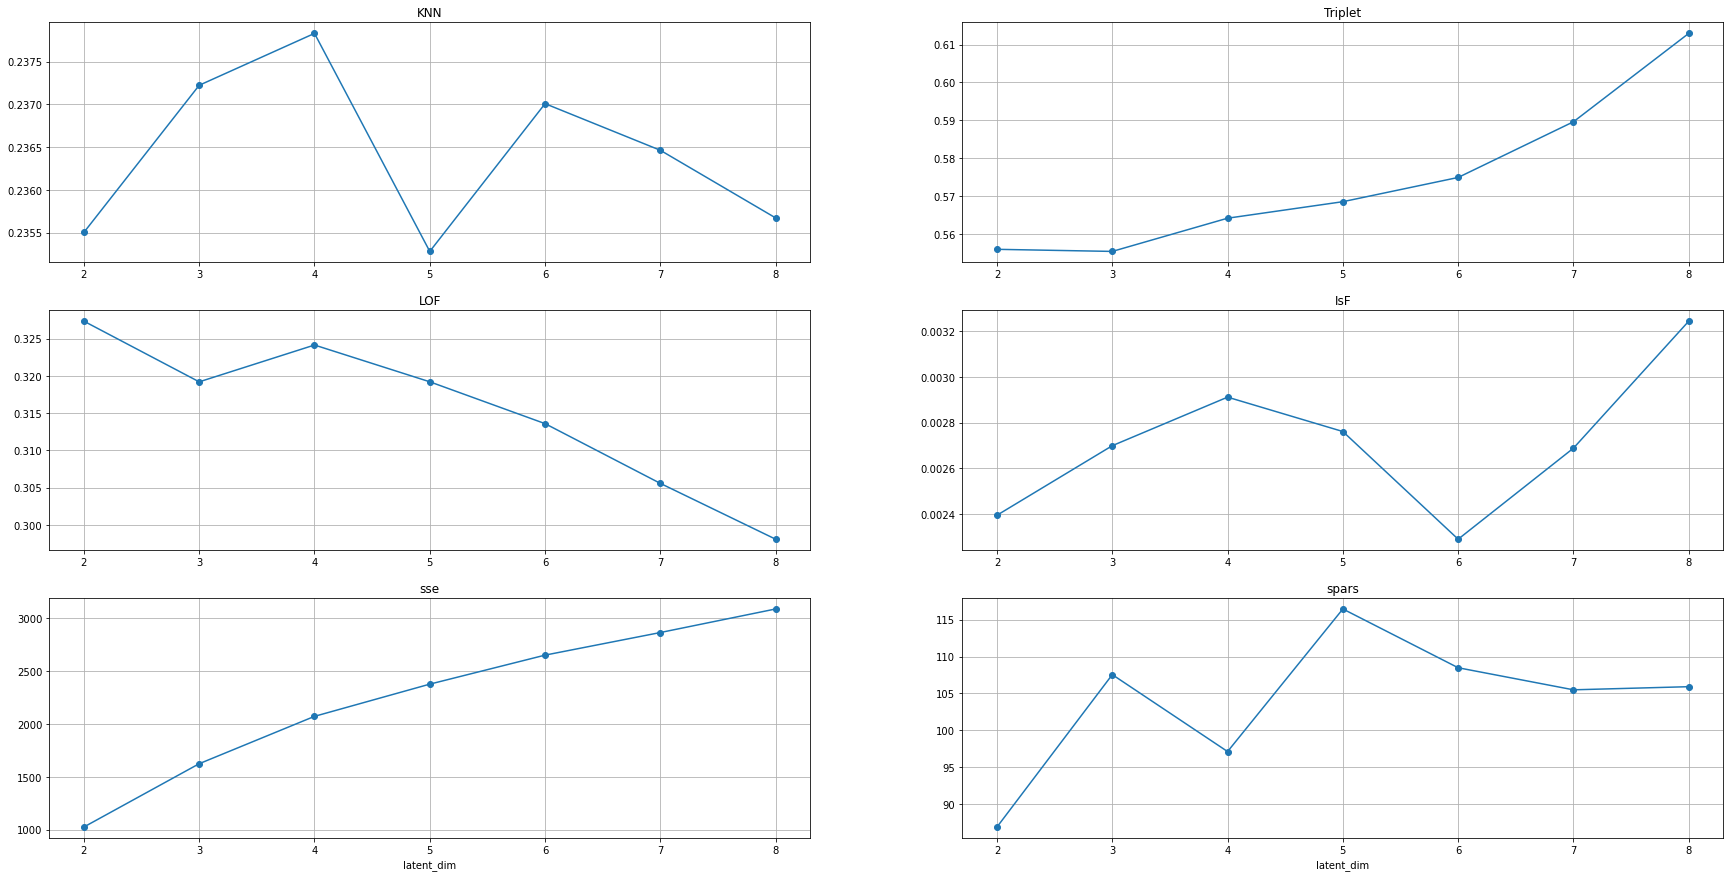

In [11]:
fig, ax = plt.subplots(3,2,figsize=(30,15))
ax.ravel()[0].plot(latent_dims,[r['KNN'] for r in metrics], '-o')
ax.ravel()[0].grid()
ax.ravel()[0].set_xticks(latent_dims)
ax.ravel()[0].set_title('KNN')
ax.ravel()[1].plot(latent_dims,[r['Triplet'] for r in metrics], '-o')
ax.ravel()[1].grid()
ax.ravel()[1].set_xticks(latent_dims)
ax.ravel()[1].set_title('Triplet')
ax.ravel()[2].plot(latent_dims,[r['LOF'] for r in metrics], '-o')
ax.ravel()[2].grid()
ax.ravel()[2].set_xticks(latent_dims)
ax.ravel()[2].set_title('LOF')
ax.ravel()[3].plot(latent_dims,[r['IsF'] for r in metrics], '-o')
ax.ravel()[3].grid()
ax.ravel()[3].set_xticks(latent_dims)
ax.ravel()[3].set_title('IsF')
ax.ravel()[4].plot(latent_dims,[r['sse'] for r in metrics], '-o')
ax.ravel()[4].grid()
ax.ravel()[4].set_xticks(latent_dims)
ax.ravel()[4].set_title('sse')
ax.ravel()[4].set_xlabel('latent_dim')
ax.ravel()[5].plot(latent_dims,[r['spars'] for r in metrics], '-o')
ax.ravel()[5].grid()
ax.ravel()[5].set_xticks(latent_dims);
ax.ravel()[5].set_title('spars')
ax.ravel()[5].set_xlabel('latent_dim')
plt.savefig(f'/Users/francescobodria/Desktop/plots/{dataset_name}_{bb_name}_alpha_{alpha}_space_metrics.jpeg', bbox_inches='tight')

In [12]:
if bb_name in ['xgb', 'rf', 'svc']:
    def predict(x, return_proba=False):
        if return_proba:
            return clf.predict_proba(x)[:,1].ravel()
        else: return clf.predict(x).ravel().ravel()
else:
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()

def compute_cf(q, indexes):
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
    if q_pred > 0.5:
        m = -0.1
    else:
        m = +0.1
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        v = np.array(model(torch.tensor(q_cf).float()).detach().numpy()+m*y_contrib)
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        #print(delta_i)
        q_cf[indexes] += delta_i
        if float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)) in q_cf_preds:
            return q_cf
        q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
        q_cf[-1] = q_cf_preds[-1]
    return q_cf

d_dists = []
d_impls = []
d_advs = []

for latent_dim in latent_dims:
    model = LinearModel(X_train.shape[1], latent_dim=latent_dim)
    model.load_state_dict(torch.load(f'./latent_analysis_models/{dataset_name}_latent_{bb_name}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()
    
    w = model.fc1.weight.detach().numpy()
    b = model.fc1.bias.detach().numpy()
    y_contrib = model.fc1.weight.detach().numpy()[:,-1]

    from itertools import combinations
    from tqdm.notebook import tqdm

    d_dist = []
    d_impl = []
    d_adv = []

    if dataset_name == 'fico':
        idx_len = 24
    elif dataset_name == 'adult':
        idx_len = 7
    elif dataset_name == 'compas':
        idx_len = 34
    elif dataset_name == 'german':
        idx_len = 72

    for idx in tqdm(range(10)):
        q = X_test[idx,:].copy()
        q_pred = predict(q[:-1].reshape(1,-1),return_proba=False)
        q_cfs = []
        l_i = []
        l_f = []

        for indexes in list(combinations(list(range(idx_len)),1)):    
            q_cf = compute_cf(q, list(indexes))
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if q_pred:
                if q_cf_pred<0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf) 

        for indexes in  list(combinations(list(range(idx_len)),2)):    
            q_cf = compute_cf(q, list(indexes))
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if q_pred:
                if q_cf_pred<0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf) 
            l_i.append([list(indexes),q_cf_pred])
        r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
        l_i = np.array(l_i,dtype=object)[r,0]

        while len(l_i[0])<6:
            for e in l_i:
                for i in list(np.delete(range(idx_len),e)):
                    q_cf = compute_cf(q, e+[i])
                    q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
                    if q_pred:
                        if q_cf_pred<0.5:
                            q_cfs.append(q_cf)
                    else:
                        if q_cf_pred>0.5:
                            q_cfs.append(q_cf) 
                    l_f.append([e+[i],q_cf_pred])
            r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
            l_f = np.array(l_f,dtype=object)[r,0]
            l_i = l_f.copy()
            l_f = []
        
        if len(q_cfs)<1:
            continue
        else:
            q_cfs = np.vstack(q_cfs)
            if dataset_name == 'fico':
                d_dist.append(np.min(cdist(q_cfs[:,:-1],q[:-1].reshape(1,-1))))
                d_impl.append(np.min(cdist(q_cfs[:,:-1],X_train[:,:-1])))
                r = np.argsort(cdist(q_cfs[:,:-1],X_train[:,:-1]),axis=1)[:,:10]
                d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
            elif dataset_name == 'compas':
                d_dist.append(np.min(cdist(q_cfs[:,13:-1],q[13:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:13],q[:13].reshape(1,-1),metric='euclidean')))
                d_impl.append(np.min(cdist(q_cfs[:,13:-1],X_train[:,13:-1],metric='hamming') + cdist(q_cfs[:,:13],X_train[:,:13],metric='euclidean')))
                r = np.argsort(cdist(q_cfs[:,13:-1],X_train[:,13:-1],metric='hamming') + cdist(q_cfs[:,:13],X_train[:,:13],metric='euclidean'),axis=1)[:,:10]
                d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
            elif dataset_name == 'adult':
                d_dist.append(np.min(cdist(q_cfs[:,[2,3,4,5,6]],q[[2,3,4,5,6]].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,[0,1]],q[[0,1]].reshape(1,-1),metric='euclidean')))
                d_impl.append(np.min(cdist(q_cfs[:,[2,3,4,5,6]],X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cfs[:,[0,1]],X_train[:,[0,1]],metric='euclidean')))
                r = np.argsort(cdist(q_cfs[:,[2,3,4,5,6]],X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cfs[:,[0,1]],X_train[:,[0,1]],metric='euclidean'),axis=1)[:,:10]
                d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
            elif dataset_name == 'german':
                d_dist.append(np.min(cdist(q_cfs[:,3:-1],q[3:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:3],q[:3].reshape(1,-1),metric='euclidean')))
                d_impl.append(np.min(cdist(q_cfs[:,3:-1],X_train[:,3:-1],metric='hamming') + cdist(q_cfs[:,:3],X_train[:,:3],metric='euclidean')))
                r = np.argsort(cdist(q_cfs[:,3:-1],X_train[:,3:-1],metric='hamming') + cdist(q_cfs[:,:3],X_train[:,:3],metric='euclidean'),axis=1)[:,:10]
                d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
    d_dists.append(np.mean(np.array(d_dist))) 
    d_impls.append(np.mean(np.array(d_impl)))
    d_advs.append(np.mean(np.array(d_adv)))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

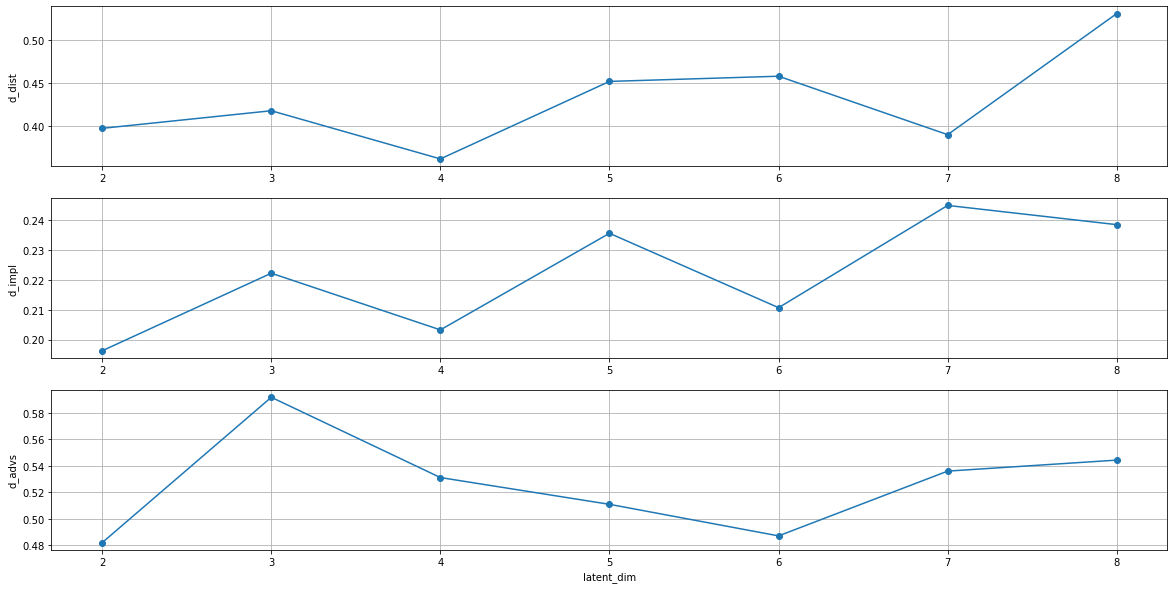

In [13]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(latent_dims,d_dists,'-o')
ax[0].set_ylabel('d_dist')
ax[0].set_xticks(latent_dims)
ax[0].grid(True)
ax[1].plot(latent_dims,d_impls,'-o')
ax[1].set_ylabel('d_impl')
ax[1].grid(True)
ax[1].set_xticks(latent_dims)
ax[2].plot(latent_dims,d_advs,'-o')
ax[2].set_xlabel('latent_dim')
ax[2].set_ylabel('d_advs')
ax[2].grid(True)
ax[2].set_xticks(latent_dims)
plt.savefig(f'/Users/francescobodria/Desktop/plots/{dataset_name}_{bb_name}_alpha_{alpha}_cf_metrics.jpeg', bbox_inches='tight')